In [9]:
import qutip as qt
import numpy as np
import sympy as sp
from qiskit import QuantumCircuit

rho_0 = sp.Matrix([[1,0],[0,0]])
rho_1 = sp.Matrix([[0,0],[0,1]])

matrix_numpy = np.array(rho_1).astype(np.complex128)

# Convert the NumPy array to a QuTiP Qobj
matrix_qutip = qt.Qobj(rho_1)
print(matrix_qutip)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0.]
 [0. 1.]]


In [10]:
def some(n=3, name='xh'):
    qc = QuantumCircuit(n, name=name)
    qc.x(0)
    qc.x(0)
    return qc

U_gate = some().to_gate()
U_gate.label = "Error"


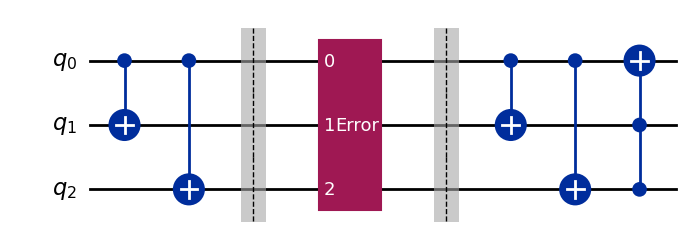

In [12]:
qc = QuantumCircuit(3)

qc.cx(0,1)
qc.cx(0,2)

qc.barrier()
qc.append(U_gate,[0,1,2])
qc.barrier()

qc.cx(0,1)
qc.cx(0,2)
qc.ccx(1,2,0)

qc.draw('mpl')

In [3]:
I = sp.Matrix([[1, 0], [0, 1]])
X = sp.Matrix([[0, 1], [1, 0]])
Y = sp.Matrix([[0, -sp.I], [sp.I, 0]])
Z = sp.Matrix([[1, 0], [0, -1]])

rx, ry, rz = sp.symbols('rx ry rz')

rho_a = (I + rx * X + ry * Y + rz * Z) / 2

rho = sp.kronecker_product(rho_a,rho_0,rho_0)

rho

Matrix([
[   rz/2 + 1/2, 0, 0, 0, rx/2 - I*ry/2, 0, 0, 0],
[            0, 0, 0, 0,             0, 0, 0, 0],
[            0, 0, 0, 0,             0, 0, 0, 0],
[            0, 0, 0, 0,             0, 0, 0, 0],
[rx/2 + I*ry/2, 0, 0, 0,    1/2 - rz/2, 0, 0, 0],
[            0, 0, 0, 0,             0, 0, 0, 0],
[            0, 0, 0, 0,             0, 0, 0, 0],
[            0, 0, 0, 0,             0, 0, 0, 0]])

In [4]:
p = sp.symbols('p')

K_0 = sp.sqrt(p)*sp.kronecker_product(X,X,I)
K_1 = sp.sqrt(1-p)*sp.kronecker_product(I,I,I)

In [5]:
U_1 = sp.kronecker_product(rho_0,I,I) + sp.kronecker_product(rho_1,X,I)
U_2 = sp.kronecker_product(rho_0,I,I) + sp.kronecker_product(rho_1,I,X)

U_4 = U_1
U_5 = U_2
U_6 = sp.kronecker_product(I,rho_0,rho_0) + sp.kronecker_product(I,rho_0,rho_1) + sp.kronecker_product(I,rho_1,rho_0) + sp.kronecker_product(X,rho_1,rho_1)

In [6]:
Ua = U_6@U_5@U_4@K_0@U_2@U_1
Ub = U_6@U_5@U_4@K_1@U_2@U_1


In [7]:
final = Ub@rho@Ub.transpose() + Ua@rho@Ua.transpose()
final
# d

Matrix([
[   (1 - p)*(rz/2 + 1/2),                 0, 0, 0, (1 - p)*(rx/2 - I*ry/2),                 0, 0, 0],
[                      0,    p*(1/2 - rz/2), 0, 0,                       0, p*(rx/2 + I*ry/2), 0, 0],
[                      0,                 0, 0, 0,                       0,                 0, 0, 0],
[                      0,                 0, 0, 0,                       0,                 0, 0, 0],
[(1 - p)*(rx/2 + I*ry/2),                 0, 0, 0,    (1/2 - rz/2)*(1 - p),                 0, 0, 0],
[                      0, p*(rx/2 - I*ry/2), 0, 0,                       0,    p*(rz/2 + 1/2), 0, 0],
[                      0,                 0, 0, 0,                       0,                 0, 0, 0],
[                      0,                 0, 0, 0,                       0,                 0, 0, 0]])

In [8]:
import sympy as sp
import itertools

def partial_trace(rho, n, qubits_to_trace_out):
    dim = 2 ** n
    
    # Define the indices for the new matrix
    remaining_qubits = sorted(set(range(n)) - set(qubits_to_trace_out))
    remaining_dim = 2 ** len(remaining_qubits)
    
    # Initialize the reduced density matrix
    reduced_rho = sp.zeros(remaining_dim, remaining_dim)
    
    # Iterate over all possible states of the remaining qubits
    for idx1, idx2 in itertools.product(range(remaining_dim), repeat=2):
        idx1_bin = format(idx1, f'0{len(remaining_qubits)}b')
        idx2_bin = format(idx2, f'0{len(remaining_qubits)}b')
        
        total_sum = 0
        for trace_state in range(2 ** len(qubits_to_trace_out)):
            trace_state_bin = format(trace_state, f'0{len(qubits_to_trace_out)}b')
            
            # Construct the full state for the original system
            full_state1 = ['0'] * n
            full_state2 = ['0'] * n
            
            for i, q in enumerate(remaining_qubits):
                full_state1[q] = idx1_bin[i]
                full_state2[q] = idx2_bin[i]
            
            for i, q in enumerate(qubits_to_trace_out):
                full_state1[q] = trace_state_bin[i]
                full_state2[q] = trace_state_bin[i]
            
            # Convert binary strings to indices
            full_index1 = int(''.join(full_state1), 2)
            full_index2 = int(''.join(full_state2), 2)
            
            total_sum += rho[full_index1, full_index2]
        
        reduced_rho[idx1, idx2] = total_sum
    
    return reduced_rho

n=3
qubits_to_trace_out = [2,1]

# Compute the reduced density matrix
reduced_rho = partial_trace(final, n, qubits_to_trace_out)

reduced_rho = sp.simplify(reduced_rho)
sp.simplify(reduced_rho)


Matrix([
[     -p*rz + rz/2 + 1/2, I*p*ry + rx/2 - I*ry/2],
[-I*p*ry + rx/2 + I*ry/2,      p*rz - rz/2 + 1/2]])

In [130]:
rho_a

Matrix([
[   rz/2 + 1/2, rx/2 - I*ry/2],
[rx/2 + I*ry/2,    1/2 - rz/2]])

We get the original matrix rho back after error correction

In [133]:
def sqrt_matrix(rho):
    rho_p,rho_d = rho.diagonalize()
    rho_d_immutable = sp.ImmutableMatrix(rho_d)

    # Convert to mutable matrix
    rho_d = sp.Matrix(rho_d_immutable)

    length = int(np.sqrt(np.size(rho_d)))

    rho_d_sqrt = sp.eye(2)

    for i in range(length):
        rho_d_sqrt[i,i] = sp.sqrt(rho_d[i,i])

    sqrtm = rho_p*rho_d_sqrt*rho_p.inv()

    return sqrtm

In [141]:
# def rho_fidelity(rho,rho_p):
sqrt_rho = sqrt_matrix(reduced_rho)
sqrt_rho = sp.simplify(sqrt_rho)
sqrt_rho
temp = sqrt_rho*rho_a*sqrt_rho
# print(1)
temp_2 = sp.simplify(temp)
temp_2
# final = sqrt_matrix(temp_2)
# final = sp.simplify(final)
# print(2)
# final_tr = sp.trace(final)

# fidelity_matrix = final_tr**2
# s_fidelity = sp.simplify(fidelity_matrix)


Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               (-8*p**3*ry**4 - 16*p**3*ry**2*rz**2 - 8*p**3*ry**2*rz - 8*p**3*rz**4 - 8*p**3*rz**3 + 4*p**2*rx**2*ry**2 + 4*p**2*rx**2*rz**2 + 12*p**2*ry**4 + 24*p**2*ry**2*rz**2 + 16*p**2*ry**2*rz + 4*p**2*ry**2 + 12*p**2*rz**4 + 16*p**2*rz**3 + 4*p**2*rz**2 - 6*p*rx**2*ry**2 - 6*p*rx**2*rz**2 + 2*p*rx**2*rz*sqrt(1 - sqrt(4*p**2*ry**2 + 4*p**2*rz**2 - 4*p*ry**2 - 4*p*rz**2 + rx**2 + ry**2 + rz**2))*sqrt(sqrt(4*p**2*ry**2 + 4*p**2*rz**2 - 4*p*ry**2 - 4*p*rz**2 + rx**2 + ry

In [ ]:
fidelity_value = s_fidelity.subs({rx:0, ry:0.9, rz:0.001})
fidelity_value

0.999999999999999